# Exploring training data and building demand models

In this dataset, we explore the training data and use the notebook as scratch space for model development.

First, we'll fit a model with just the linear growth in demand, plus the trig terms to account for seasonality.

In [491]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [492]:
df = pd.read_csv('./../data/processed/train.csv.gz', parse_dates=[0],index_col=0)

In [493]:
df = df.sort_index()

In [494]:
df.head()

,Trip Count,Day of Week,Month,t,cos_t,sin_t,Last_week_average,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,WSF2,WSF5,WT01,WT08
Date,,,,,,,,,,,,,,,,,
2014-01-13,20633,0,1,12,0.978769,0.978769,5221.428571,-0.350441,-0.13522,-0.283686,-0.706344,-0.716210,-0.041367,0.063282,0.240564,0,0
2014-01-14,9999,1,1,13,0.975099,0.975099,5676.714286,0.716532,-0.13522,-0.283686,-0.658186,-0.312773,-0.140402,-0.236328,-0.081169,1,0
2014-01-16,19953,3,1,15,0.966893,0.966893,7599.142857,-0.350441,-0.13522,-0.283686,-1.187922,-0.778277,-0.536543,-1.015315,-1.332352,0,0
2014-01-17,20301,4,1,16,0.962360,0.962360,8371.000000,-0.350441,-0.13522,-0.283686,-1.081975,-0.943790,-0.734614,-0.476016,-0.545894,0,0
2014-01-18,9438,5,1,17,0.957543,0.957543,9776.285714,-0.152446,-0.13522,-0.283686,-1.245711,-1.171370,0.849951,0.302970,0.419305,0,0


In [495]:
from sklearn.linear_model import LinearRegression

In [496]:
baseline_features = ['t','cos_t','sin_t']
target = 'Trip Count'

In [497]:
lr = LinearRegression()

In [498]:
lr.fit(df[baseline_features],df[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [499]:
predictions = lr.predict(df[baseline_features])

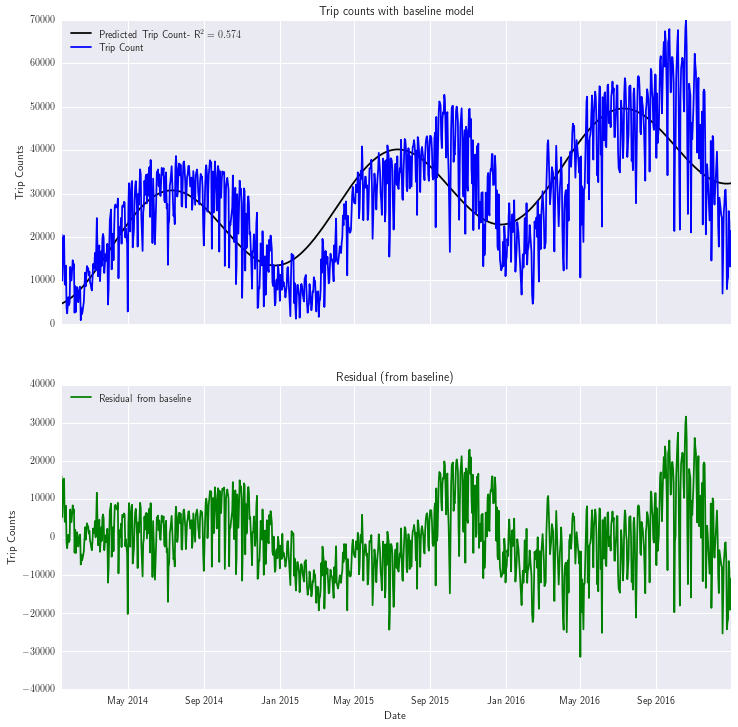

In [472]:
plt.rc('text', usetex=True)

f, axarr = plt.subplots(2, sharex=True, figsize=(12,12))
axarr[0].plot(df.index, predictions, color='k', label='Predicted Trip Count- R^2 = {0:.3f}'.format(lr.score(df[baseline_features],df[target])))
axarr[0].plot(df.index,df['Trip Count'], color='b')
axarr[0].set_ylabel('Trip Counts')
axarr[0].set_title('Trip counts with baseline model')
axarr[0].legend(loc='upper left')
axarr[1].plot(df.index,df['Trip Count'] - predictions, color='g', label='Residual from baseline')
axarr[1].set_ylabel('Trip Counts')
axarr[1].set_xlabel('Date')
axarr[1].set_title(r'Residual (from baseline)')
axarr[1].legend(loc="upper left")

Next we fit a regularized model using all available features. To avoid regularizing the original features, we scale these features to be very large (so only a small coefficient is needed).

In [473]:
for feature in baseline_features:
    df[feature] = df[feature]*1e6

In [474]:
df = df.join(pd.get_dummies(df['Day of Week'], prefix='day',drop_first=False))
df = df.drop('Day of Week', axis=1)
df = df.join(pd.get_dummies(df['Month'], prefix='month',drop_first=False))
df = df.drop('Month', axis=1)

In [475]:
from sklearn.linear_model import ElasticNetCV

In [476]:
l1_ratio = np.arange(0,1.1,.1)
alphas = np.logspace(-3,4,8)
cv = 5
verbose = 2
fit_intercept = False #note center data using previous model

In [477]:
EN = ElasticNetCV(l1_ratio=l1_ratio,
                  alphas=alphas,
                  cv=cv,
                  selection='random',
                  random_state=34631)

In [478]:
features = list(set(df.columns) - set(['Trip Count']))

In [480]:
EN.fit(df[features], df['Trip Count'])

ElasticNetCV(alphas=array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03,   1.00000e+04]),
       copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
       max_iter=1000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=34631,
       selection='random', tol=0.0001, verbose=0)

In [481]:
EN.score(df[features], df['Trip Count'])

0.87255839911757693

In [482]:
EN.l1_ratio_

0.5

In [483]:
EN.alpha_

0.10000000000000001

In [484]:
for i in range(len(features)):
    print 'Feature: {0}, Coefficient: {1:.3f}'.format(features[i], EN.coef_[i])

Feature: TMIN, Coefficient: 804.933
Feature: SNWD, Coefficient: -492.926
Feature: sin_t, Coefficient: 0.003
Feature: month_12, Coefficient: -1284.986
Feature: month_10, Coefficient: 1196.833
Feature: month_11, Coefficient: -527.280
Feature: month_4, Coefficient: 591.381
Feature: month_5, Coefficient: 117.918
Feature: month_6, Coefficient: 305.985
Feature: month_7, Coefficient: -1437.950
Feature: WT08, Coefficient: -723.050
Feature: month_2, Coefficient: 604.217
Feature: month_3, Coefficient: 762.928
Feature: day_2, Coefficient: 2293.648
Feature: day_3, Coefficient: 2095.264
Feature: day_0, Coefficient: 487.638
Feature: day_1, Coefficient: 1991.731
Feature: month_8, Coefficient: -1170.464
Feature: WSF5, Coefficient: -561.334
Feature: day_4, Coefficient: 1016.444
Feature: day_5, Coefficient: -3488.016
Feature: cos_t, Coefficient: -0.003
Feature: Last_week_average, Coefficient: 0.512
Feature: WT01, Coefficient: -2598.978
Feature: AWND, Coefficient: -659.282
Feature: WSF2, Coefficient: 205

In [485]:
final_predictions = EN.predict(df[features])

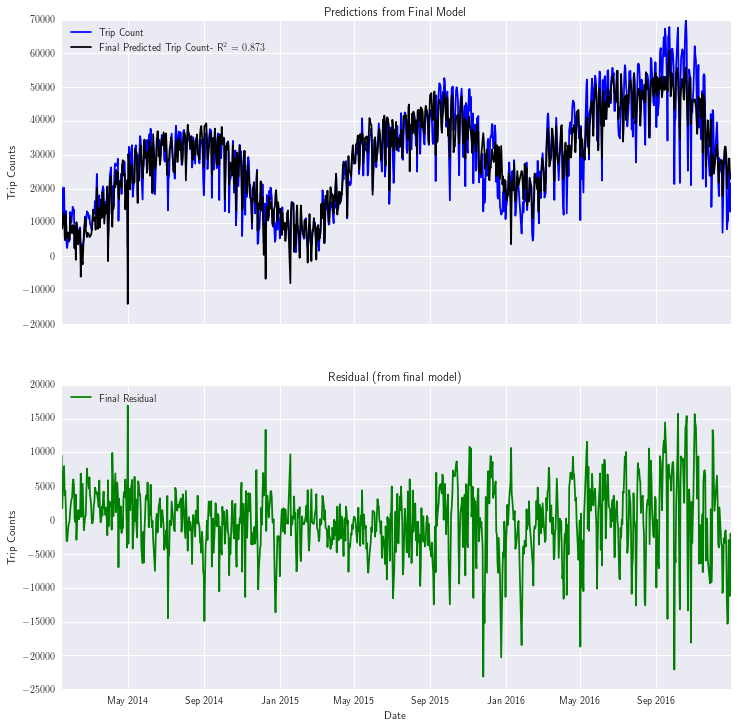

In [488]:
f, axarr = plt.subplots(2, sharex=True, figsize=(12,12))
axarr[0].plot(df.index,df['Trip Count'], color='b', label='Trip Count')
axarr[0].plot(df.index, final_predictions, color='k', label=r'Final Predicted Trip Count- R^2 = {0:.3f}'.format(EN.score(df[features], df['Trip Count'])))
axarr[0].set_ylabel('Trip Counts')
axarr[0].set_title('Predictions from Final Model')
axarr[0].legend(loc='upper left')
axarr[1].plot(df.index,df['Trip Count'] - final_predictions, color='g', label='Final Residual')
axarr[1].set_ylabel('Trip Counts')
axarr[1].set_xlabel('Date')
axarr[1].set_title(r'Residual (from final model)')
axarr[1].legend(loc="upper left")